# Tarea: ExperimentaciÃ³n con Redes Neuronales Convolucionales (CNN)
## Computer Vision con TensorFlow

**Objetivo**: Explorar cÃ³mo diferentes arquitecturas convolucionales y tÃ©cnicas de regularizaciÃ³n afectan el desempeÃ±o en tareas de clasificaciÃ³n de imÃ¡genes usando el dataset CIFAR-10.

---

## Instrucciones Generales

En este ejercicio trabajarÃ¡s con el dataset CIFAR-10 (imÃ¡genes de 32x32 pÃ­xeles en 10 categorÃ­as) y arquitecturas de redes neuronales convolucionales. El cÃ³digo base ya estÃ¡ en su mayorÃ­a implementado, tu trabajo consistirÃ¡ en:

1. Completar partes especÃ­ficas del cÃ³digo segÃºn las instrucciones
2. Ejecutar 10 experimentos modificando arquitecturas y parÃ¡metros
3. Analizar los resultados de cada experimento
4. Responder las preguntas especÃ­ficas de cada ejercicio

**Entrega**: Completa todos los ejercicios en este notebook, ejecuta las celdas correspondientes, y responde las preguntas en las celdas de markdown proporcionadas. El notebook se sube a github y el enlace de github se sube al GES.

**Nota**: Al final del notebook se presenta un ejemplo  de como crear un modelo que lee imÃ¡genes de disco(organizando las clases por directorio), esto es Ãºtil para casos en donde el dataset no cabe en memoria ya que permite hacer lectura del disco por batches, este ejemplo no tiene ningÃºn ejercicio por completar, solo estÃ¡ como referencia

---
## ConfiguraciÃ³n Inicial y CÃ³digo Base

In [3]:
# Imports necesarios
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

# ConfiguraciÃ³n para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Verificar versiÃ³n de TensorFlow y disponibilidad de GPU
print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {len(tf.config.list_physical_devices("GPU")) > 0}')
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f'GPU: {tf.config.list_physical_devices("GPU")[0].name}')

TensorFlow version: 2.20.0
GPU disponible: False


E0000 00:00:1764127892.036449   36207 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764127892.043897   36207 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Cargar el dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Nombres de las clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f'Forma de X_train: {X_train.shape}')
print(f'Forma de y_train: {y_train.shape}')
print(f'Forma de X_test: {X_test.shape}')
print(f'Forma de y_test: {y_test.shape}')
print(f'\nRango de valores de pÃ­xeles: [{X_train.min()}, {X_train.max()}]')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Forma de X_train: (50000, 32, 32, 3)
Forma de y_train: (50000, 1)
Forma de X_test: (10000, 32, 32, 3)
Forma de y_test: (10000, 1)

Rango de valores de pÃ­xeles: [0, 255]


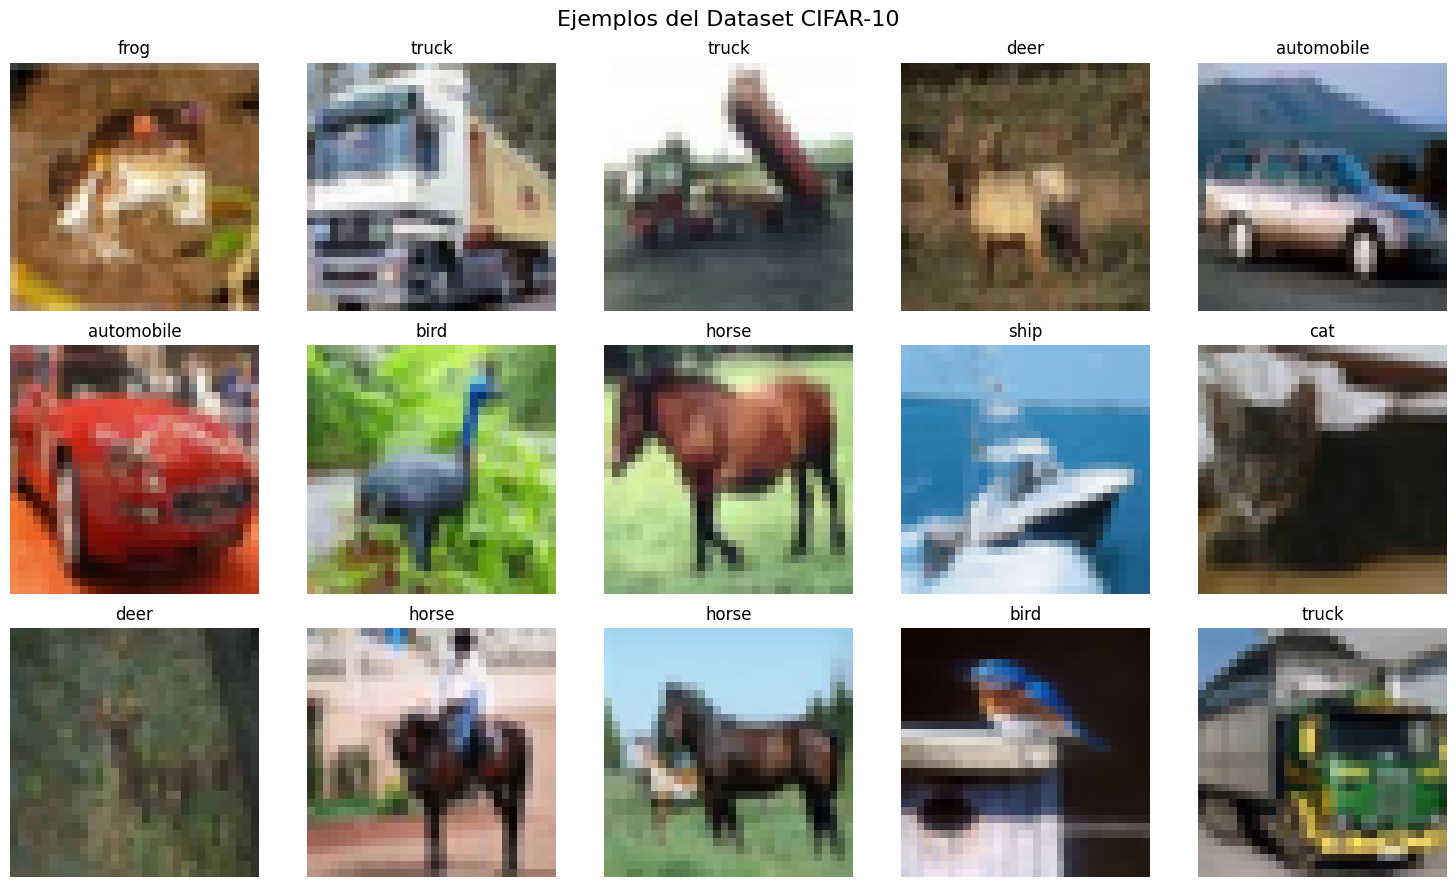

In [5]:
# Visualizar algunos ejemplos del dataset
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f'{class_names[y_train[i][0]]}')
    ax.axis('off')
plt.suptitle('Ejemplos del Dataset CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# Preprocesamiento de datos
def preprocess_data(X_train, y_train, X_test, y_test):
    """
    Normaliza las imÃ¡genes y convierte las etiquetas a one-hot encoding.
    """
    # Normalizar pÃ­xeles al rango [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # One-hot encoding de las etiquetas
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return X_train, y_train, X_test, y_test

X_train_processed, y_train_processed, X_test_processed, y_test_processed = preprocess_data(
    X_train, y_train, X_test, y_test
)

print('Preprocesamiento completado:')
print(f'X_train shape: {X_train_processed.shape}')
print(f'y_train shape: {y_train_processed.shape}')
print(f'Rango de pÃ­xeles normalizados: [{X_train_processed.min():.2f}, {X_train_processed.max():.2f}]')

Preprocesamiento completado:
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
Rango de pÃ­xeles normalizados: [0.00, 1.00]


### FunciÃ³n Builder de CNN Flexible

In [7]:
def build_cnn(input_shape=(32, 32, 3), num_classes=10, conv_layers=None, 
              dense_layers=[128], dropout_rate=0.0, use_batch_norm=False,
              l2_reg=0.0):
    """
    Construye una CNN flexible.
    
    Args:
        input_shape: Forma de la imagen de entrada
        num_classes: NÃºmero de clases
        conv_layers: Lista de diccionarios con configuraciÃ³n de capas convolucionales
                     Ejemplo: [{'filters': 32, 'kernel_size': 3, 'pool_size': 2}]
        dense_layers: Lista con nÃºmero de neuronas en capas densas
        dropout_rate: Tasa de dropout (0 = sin dropout)
        use_batch_norm: Si usar batch normalization
        l2_reg: Factor de regularizaciÃ³n L2
    
    Returns:
        Modelo de Keras compilado
    """
    if conv_layers is None:
        conv_layers = [
            {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
            {'filters': 64, 'kernel_size': 3, 'pool_size': 2}
        ]
    
    regularizer = keras.regularizers.l2(l2_reg) if l2_reg > 0 else None
    
    model = models.Sequential()
    
    # Primera capa convolucional
    model.add(layers.Input(shape=input_shape))
    
    # Capas convolucionales
    for i, conv_config in enumerate(conv_layers):
        model.add(layers.Conv2D(
            filters=conv_config['filters'],
            kernel_size=conv_config['kernel_size'],
            padding='same',
            activation='relu',
            kernel_regularizer=regularizer,
            name=f'conv_{i+1}'
        ))
        
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        
        if 'pool_size' in conv_config:
            model.add(layers.MaxPooling2D(
                pool_size=conv_config['pool_size'],
                name=f'pool_{i+1}'
            ))
        
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Aplanar
    model.add(layers.Flatten())
    
    # Capas densas
    for i, units in enumerate(dense_layers):
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=regularizer,
            name=f'dense_{i+1}'
        ))
        
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Capa de salida
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model

print('FunciÃ³n build_cnn definida correctamente')

FunciÃ³n build_cnn definida correctamente


### Funciones de Entrenamiento y VisualizaciÃ³n

In [12]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, 
                       epochs=20, batch_size=64, learning_rate=0.001,
                       experiment_name="Experimento", use_data_augmentation=False):
    """
    Entrena y evalÃºa un modelo CNN.
    
    Args:
        model: Modelo de Keras
        X_train, y_train: Datos de entrenamiento
        X_test, y_test: Datos de prueba
        epochs: NÃºmero de Ã©pocas
        batch_size: TamaÃ±o del batch
        learning_rate: Tasa de aprendizaje
        experiment_name: Nombre del experimento
        use_data_augmentation: Si usar data augmentation
    
    Returns:
        Diccionario con resultados y historia del entrenamiento
    """
    print(f"\n{'='*70}")
    print(f"{experiment_name}")
    print(f"{'='*70}\n")
    
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Mostrar arquitectura
    print("Arquitectura del modelo:")
    model.summary()
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=0
        )
    ]
    
    # Data augmentation si estÃ¡ activado
    if use_data_augmentation:
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
        datagen.fit(X_train)
        print("\n[INFO] Usando Data Augmentation")
    
    # Entrenamiento
    print("\nIniciando entrenamiento...\n")
    start_time = time()
    
    if use_data_augmentation:
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
    
    training_time = time() - start_time
    
    # EvaluaciÃ³n final
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n{'='*70}")
    print(f"Resultados Finales:")
    print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print(f"{'='*70}\n")
    
    # VisualizaciÃ³n
    plot_training_history(history, experiment_name)
    
    return {
        'history': history.history,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'training_time': training_time,
        'epochs_trained': len(history.history['loss'])
    }


def plot_training_history(history, title="Training History"):
    """
    Visualiza la historia del entrenamiento.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    ax1.set_xlabel('Ã‰poca', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('PÃ©rdida durante el Entrenamiento', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
    ax2.set_xlabel('Ã‰poca', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('PrecisiÃ³n durante el Entrenamiento', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

print('Funciones de entrenamiento y visualizaciÃ³n definidas correctamente')

Funciones de entrenamiento y visualizaciÃ³n definidas correctamente


---
---
# EJERCICIOS

A continuaciÃ³n se presentan 10 ejercicios donde deberÃ¡s completar partes del cÃ³digo, modificar arquitecturas y analizar resultados.

---
## Ejercicio 1: CNN Baseline Simple

**Objetivo**: Construir y entrenar una CNN bÃ¡sica de 2 capas convolucionales para establecer un baseline.

**ConfiguraciÃ³n ya dada**:
- 2 bloques convolucionales con 32 y 64 filtros
- Kernel size 3x3, MaxPooling 2x2
- 1 capa densa de 128 neuronas
- 20 Ã©pocas, batch_size=64, learning_rate=0.001


Ejercicio 1: CNN Baseline Simple

Arquitectura del modelo:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4974 - loss: 1.4106 - val_accuracy: 0.5999 - val_loss: 1.1315
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6288 - loss: 1.0560 - val_accuracy: 0.6522 - val_loss: 1.0021
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6787 - loss: 0.9241 - val_accuracy: 0.6795 - val_loss: 0.9339
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7117 - loss: 0.8311 - val_accuracy: 0.6864 - val_loss: 0.9169
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7408 - loss: 0.7516 - val_accuracy: 0.6880 - val_loss: 0.9186
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7668 - loss: 0.6810 - val_accuracy: 0.6865 - val_loss: 0.9512
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7896 - loss: 0.6144 - val_accuracy: 0.6854 - val_loss: 0.9787
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8094 

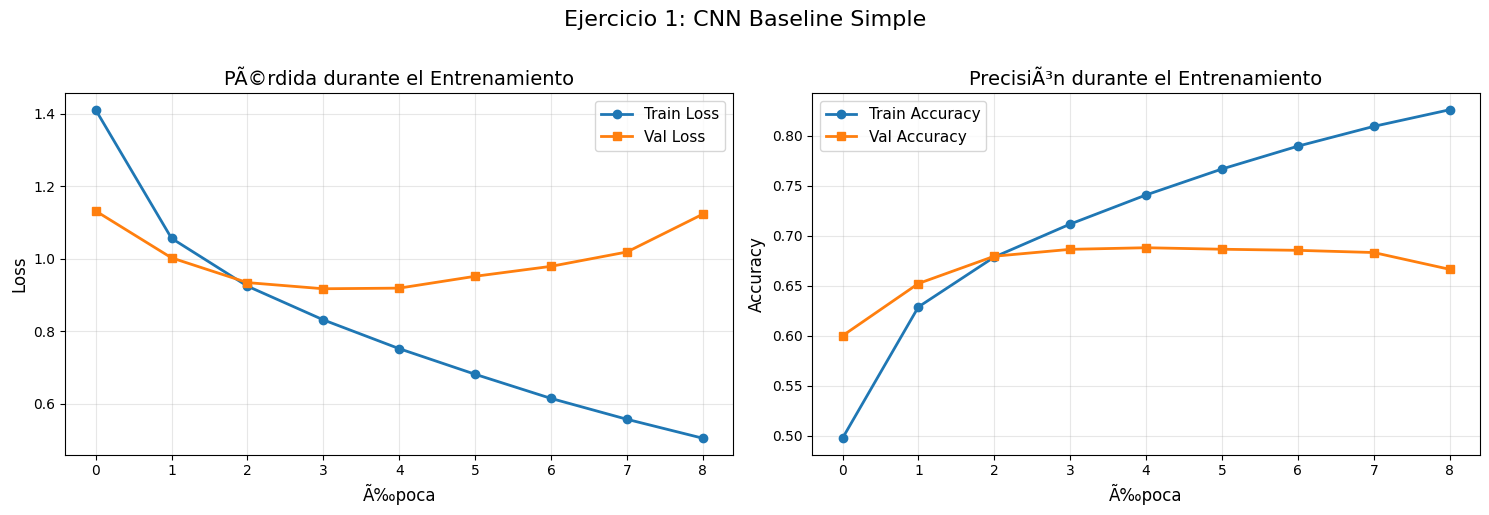

In [14]:
# Ejercicio 1: CNN Baseline
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2}
]

model_ex1 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False
)

results_ex1 = train_and_evaluate(
    model_ex1,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 1: CNN Baseline Simple"
)

### Respuestas Ejercicio 1

**1.1** Â¿CuÃ¡l fue la exactitud final en el conjunto de test?

69.31%

**1.2** Â¿Observas overfitting? Â¿CÃ³mo lo identificas en las grÃ¡ficas?

En efecto asi parece, dado a que la gráfica de la precision del entrenamiento es bastante más alta comparado con el valor de testing final.

**1.3** Â¿CuÃ¡ntas Ã©pocas tomÃ³ antes de que el early stopping detuviera el entrenamiento (si aplica)?

10

---
## Ejercicio 2: Agregar una Tercera Capa Convolucional

**Objetivo**: Explorar el efecto de hacer la red mÃ¡s profunda.

**TAREA**: Completa el cÃ³digo agregando una tercera capa convolucional con:
- **128 filtros**
- **Kernel size de 3x3**
- **MaxPooling de 2x2**

**Pregunta**: Â¿Una red mÃ¡s profunda mejora automÃ¡ticamente los resultados?


Ejercicio 2: CNN con 3 Capas Convolucionales

Arquitectura del modelo:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4771 - loss: 1.4500 - val_accuracy: 0.6045 - val_loss: 1.1139
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6412 - loss: 1.0184 - val_accuracy: 0.6764 - val_loss: 0.9383
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7063 - loss: 0.8416 - val_accuracy: 0.7027 - val_loss: 0.8777
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7493 - loss: 0.7261 - val_accuracy: 0.7196 - val_loss: 0.8318
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7820 - loss: 0.6329 - val_accuracy: 0.7224 - val_loss: 0.8384
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8056 - loss: 0.5616 - val_accuracy: 0.7280 - val_loss: 0.8572
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8246 - loss: 0.5024 - val_accuracy: 0.7288 - val_loss: 0.8899
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accur

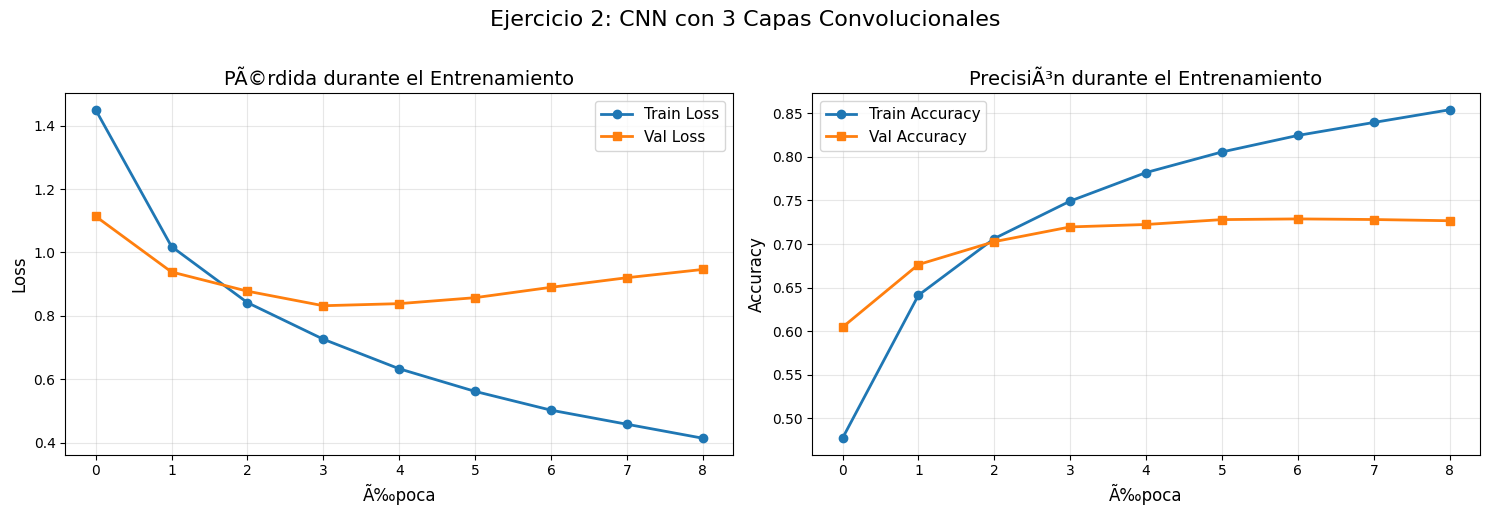

In [15]:
# Ejercicio 2: Agregar tercera capa convolucional

# TODO: Completa la configuraciÃ³n agregando la tercera capa convolucional
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2},
    # AGREGA AQUÃ la tercera capa con 128 filtros, kernel 3x3, pool 2x2
]

model_ex2 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False
)

results_ex2 = train_and_evaluate(
    model_ex2,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 2: CNN con 3 Capas Convolucionales"
)

### Respuestas Ejercicio 2

**2.1** Â¿MejorÃ³ la exactitud comparada con el baseline?

Si, en este caso subio de 68.64% a 71.96%.

**2.2** Â¿El tiempo de entrenamiento aumentÃ³ significativamente?

Si tuvo un aumento de 26.74 segundos, lo que equivale a que es 137% en tiempo original.

**2.3** Â¿Hay mÃ¡s o menos overfitting que en el Ejercicio 1?

Si, se aprecia bastante similar.

---
## Ejercicio 3: Implementar Dropout

**Objetivo**: Usar dropout como tÃ©cnica de regularizaciÃ³n para reducir overfitting.

**TAREA**: El cÃ³digo ya estÃ¡ casi completo. Debes cambiar el parÃ¡metro `dropout_rate` de 0.0 a **0.5**

**Pregunta**: Â¿CÃ³mo afecta el dropout al overfitting y a la exactitud en entrenamiento vs test?


Ejercicio 3: CNN con Dropout (0.5)

Arquitectura del modelo:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3124 - loss: 1.8391 - val_accuracy: 0.4537 - val_loss: 1.5310
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4445 - loss: 1.5229 - val_accuracy: 0.5286 - val_loss: 1.3482
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4934 - loss: 1.4012 - val_accuracy: 0.5579 - val_loss: 1.2545
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5282 - loss: 1.3212 - val_accuracy: 0.5933 - val_loss: 1.1579
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5459 - loss: 1.2712 - val_accuracy: 0.5337 - val_loss: 1.2909
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5625 - loss: 1.2288 - val_accuracy: 0.6129 - val_loss: 1.1090
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5743 - loss: 1.1998 - val_accuracy: 0.6028 - val_loss: 1.1094
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accur

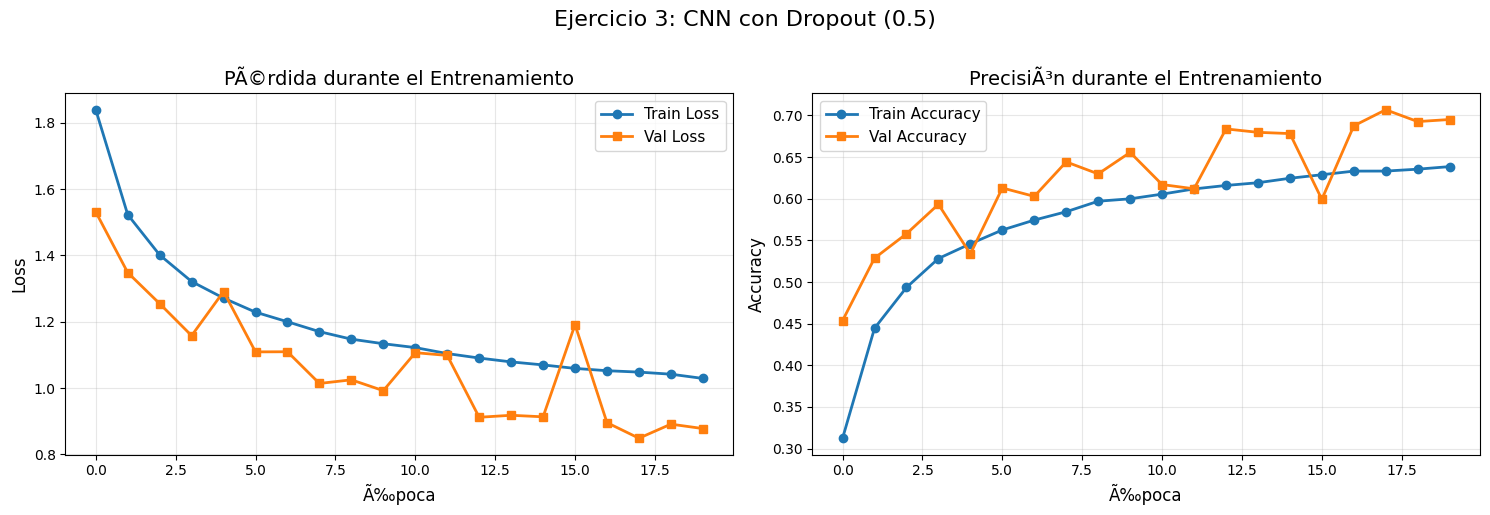

In [16]:
# Ejercicio 3: Implementar Dropout
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

# TODO: Cambia dropout_rate a 0.5
model_ex3 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.5,  # CAMBIA ESTE VALOR A 0.5
    use_batch_norm=False
)

results_ex3 = train_and_evaluate(
    model_ex3,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 3: CNN con Dropout (0.5)"
)

### Respuestas Ejercicio 3

**3.1** Â¿Se redujo la brecha entre train accuracy y val accuracy?

En efecto si, se ve una difrencia aproximada de 5 puntos porcentuales.

**3.2** Â¿La exactitud en test mejorÃ³ o empeorÃ³ comparada con el Ejercicio 2?

empeora levemente, de 71.96% a 70.68%.

**3.3** Â¿En quÃ© momento del entrenamiento es mÃ¡s visible el efecto del dropout?

Creo que en la epoch 15 hay un abruta radical, donde se puede notar que pued estar sucediedo un underfitting, que nace del aumento del dropout.

---
## Ejercicio 4: Batch Normalization

**Objetivo**: Implementar batch normalization para mejorar la estabilidad del entrenamiento.

**TAREA**: Activa batch normalization cambiando `use_batch_norm` de False a **True**

**Pregunta**: Â¿CÃ³mo afecta la batch normalization a la velocidad de convergencia?


Ejercicio 4: CNN con Batch Normalization

Arquitectura del modelo:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5974 - loss: 1.1495 - val_accuracy: 0.6046 - val_loss: 1.1771
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7231 - loss: 0.7947 - val_accuracy: 0.6852 - val_loss: 0.9286
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.7834 - loss: 0.6260 - val_accuracy: 0.7061 - val_loss: 0.9001
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8245 - loss: 0.5048 - val_accuracy: 0.6907 - val_loss: 0.9604
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.8628 - loss: 0.3992 - val_accuracy: 0.6623 - val_loss: 1.1807
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8973 - loss: 0.2986 - val_accuracy: 0.6545 - val_loss: 1.3153
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9219 - loss: 0.2288 - val_accuracy: 0.6985 - val_loss: 1.2007
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accur

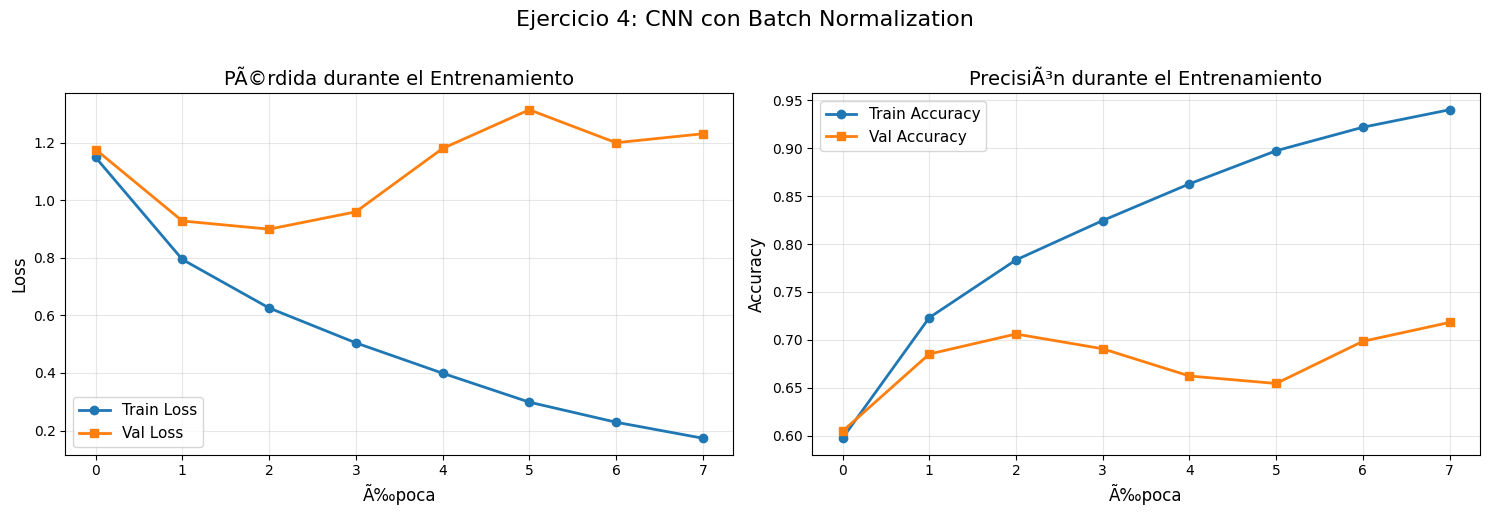

In [18]:
# Ejercicio 4: Batch Normalization
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

# TODO: Cambia use_batch_norm a True
model_ex4 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=True  # CAMBIA ESTE VALOR A True
)

results_ex4 = train_and_evaluate(
    model_ex4,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 4: CNN con Batch Normalization"
)

### Respuestas Ejercicio 4

**4.1** Â¿La red converge mÃ¡s rÃ¡pido con batch normalization?

En efecto si, solo se tarda 7 epochs.

**4.2** Â¿CÃ³mo se compara la exactitud final con los ejercicios anteriores?

bastante similar 70.67%, lo cual no varia mucho en loas casos anteriores.

**4.3** Â¿Las curvas de loss son mÃ¡s suaves?

En efecto si, se ven ligeramente mas suaves, especialmente comparadas con el ejercicio 3.

---
## Ejercicio 5: Aumentar el Learning Rate

**Objetivo**: Experimentar con un learning rate mÃ¡s alto.

**ConfiguraciÃ³n**: Usa el modelo del Ejercicio 4 (con batch norm) pero con learning_rate=0.01 (10x mÃ¡s alto)

**Pregunta**: Â¿CÃ³mo afecta un learning rate alto cuando se usa batch normalization?


Ejercicio 5: Learning Rate Alto (0.01) + Batch Norm

Arquitectura del modelo:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.4288 - loss: 1.6298 - val_accuracy: 0.3729 - val_loss: 2.1388
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5497 - loss: 1.2904 - val_accuracy: 0.5264 - val_loss: 1.5369
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6120 - loss: 1.1246 - val_accuracy: 0.5527 - val_loss: 1.3869
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6478 - loss: 1.0406 - val_accuracy: 0.5618 - val_loss: 1.8779
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6746 - loss: 0.9741 - val_accuracy: 0.4970 - val_loss: 2.1475
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6983 - loss: 0.8964 - val_accuracy: 0.5026 - val_loss: 2.0765
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7262 - loss: 0.8286 - val_accuracy: 0.5346 - val_loss: 1.8942
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accur

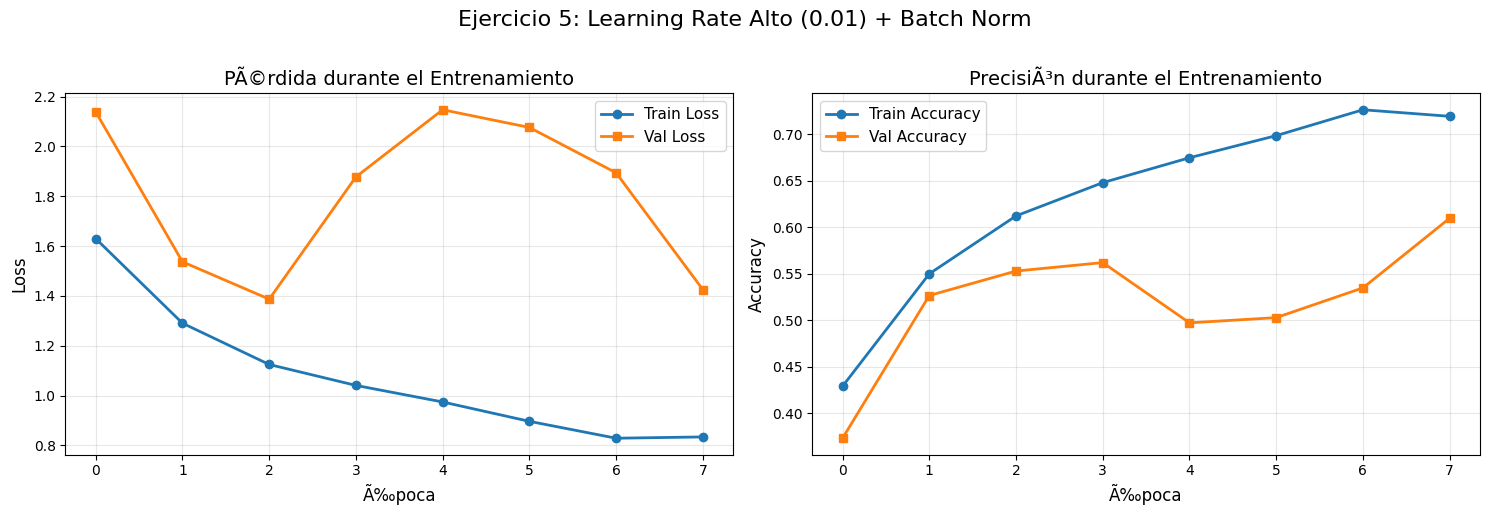

In [19]:
# Ejercicio 5: Learning Rate Alto con Batch Normalization
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex5 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=True
)

results_ex5 = train_and_evaluate(
    model_ex5,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.1,  # 10x mÃ¡s alto
    experiment_name="Ejercicio 5: Learning Rate Alto (0.01) + Batch Norm"
)

### Respuestas Ejercicio 5

**5.1** Â¿El entrenamiento es estable con este learning rate?

No, es más inestable que los casos anteriores.

**5.2** Â¿La convergencia es mÃ¡s rÃ¡pida comparada con learning_rate=0.001?

No, al igual que el ejercicio anterior, converge a los 7 epochs.

**5.3** Â¿Por quÃ© batch normalization permite usar learning rates mÃ¡s altos?

Porque batch normalization previene los cambios bruscos en el gradiente.

---
## Ejercicio 6: Data Augmentation

**Objetivo**: Implementar data augmentation para mejorar la generalizaciÃ³n.

**ConfiguraciÃ³n**: Usa una CNN simple con data augmentation activado.

**Pregunta**: Â¿CÃ³mo ayuda el data augmentation a reducir el overfitting?


Ejercicio 6: Data Augmentation

Arquitectura del modelo:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


[INFO] Usando Data Augmentation

Iniciando entrenamiento...

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.4331 - loss: 1.5579 - val_accuracy: 0.5417 - val_loss: 1.2458
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5737 - loss: 1.1991 - val_accuracy: 0.6276 - val_loss: 1.0581
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6283 - loss: 1.0506 - val_accuracy: 0.6860 - val_loss: 0.8954
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6644 - loss: 0.9609 - val_accuracy: 0.6866 - val_loss: 0.9042
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.6841 - loss: 0.9015 - val_accuracy: 0.7234 - val_loss: 0.8097
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7028 - loss: 0.8486 - val_accuracy: 0.7104 - val_loss: 0.8223
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7150 - loss: 0.8178 - val_accuracy: 0.7168 - val_loss: 0.8379
Epoch 8/30
782/782 ━━━━━━━━━

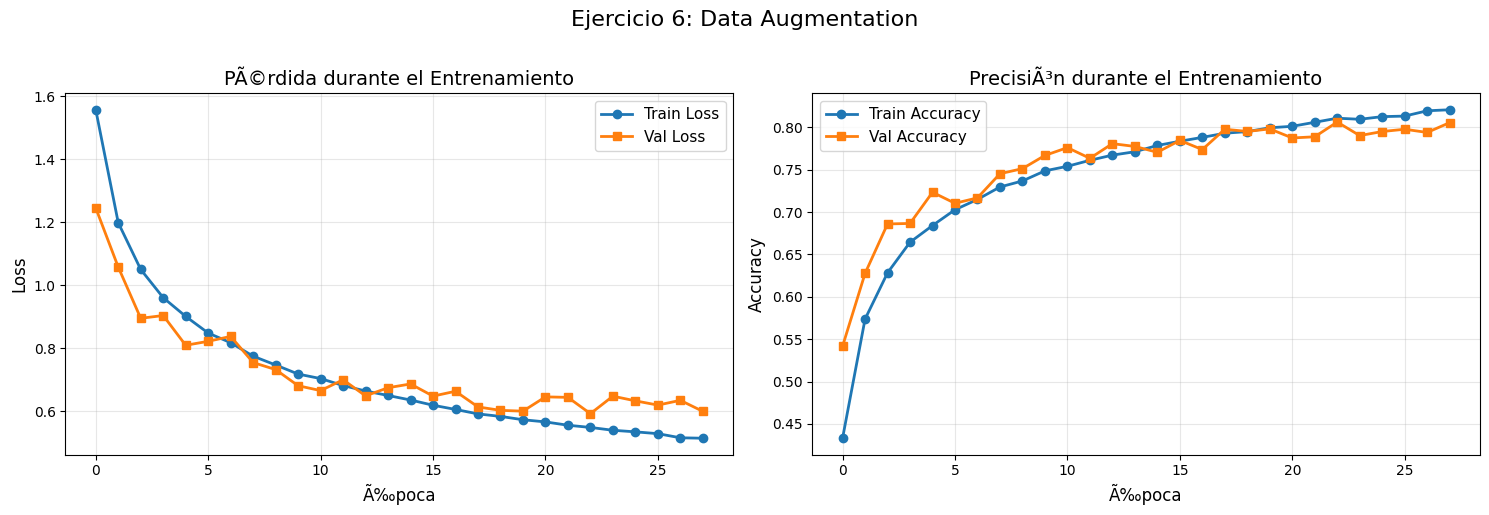

In [21]:
# Ejercicio 6: Data Augmentation
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex6 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False
)

results_ex6 = train_and_evaluate(
    model_ex6,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=30,  # MÃ¡s Ã©pocas porque data augmentation requiere mÃ¡s tiempo
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 6: Data Augmentation",
    use_data_augmentation=True  # ACTIVADO
)

### Respuestas Ejercicio 6

**6.1** Â¿La exactitud en training es mÃ¡s baja con data augmentation? Â¿Por quÃ©?

Es similar al menos con respecto al ejercicio base.

**6.2** Â¿MejorÃ³ la exactitud en el conjunto de test?

Aumentó considerablemente a 10 puntos porcentuales comparandolos con los casos anteriores

**6.3** Â¿El overfitting se redujo?

En efecto si, dado a que ahora las gráficas del testing y del training son más similares.

---
## Ejercicio 7: RegularizaciÃ³n L2

**Objetivo**: Explorar la regularizaciÃ³n L2 (weight decay) en las capas convolucionales.

**TAREA**: Agrega regularizaciÃ³n L2 modificando el parÃ¡metro `l2_reg` a **0.001**

**Pregunta**: Â¿CÃ³mo compara la regularizaciÃ³n L2 con dropout?


Ejercicio 7: RegularizaciÃ³n L2 (0.001)

Arquitectura del modelo:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4658 - loss: 1.6343 - val_accuracy: 0.5709 - val_loss: 1.3734
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6067 - loss: 1.2918 - val_accuracy: 0.6332 - val_loss: 1.2313
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6595 - loss: 1.1735 - val_accuracy: 0.6789 - val_loss: 1.1400
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6908 - loss: 1.0966 - val_accuracy: 0.6933 - val_loss: 1.1072
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7126 - loss: 1.0471 - val_accuracy: 0.6996 - val_loss: 1.0957
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7310 - loss: 1.0078 - val_accuracy: 0.7044 - val_loss: 1.0997
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7469 - loss: 0.9745 - val_accuracy: 0.7068 - val_loss: 1.0961
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accur

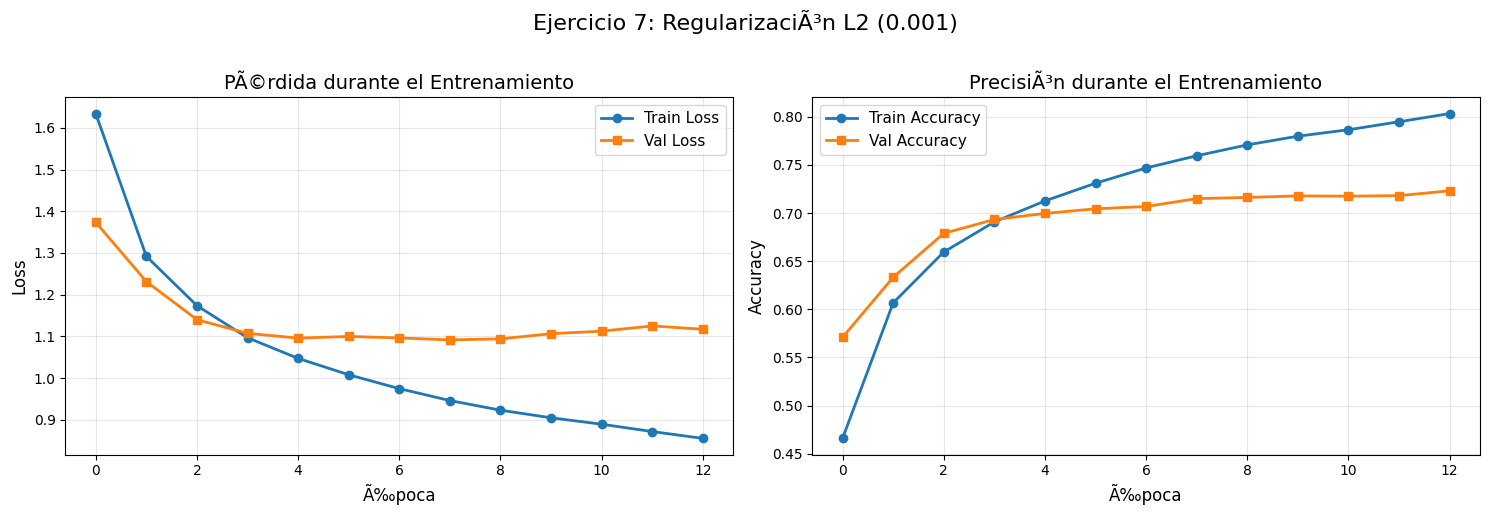

In [23]:
# Ejercicio 7: RegularizaciÃ³n L2
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

# TODO: Cambia l2_reg a 0.001
model_ex7 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.0,
    use_batch_norm=False,
    l2_reg=0.001  # CAMBIA ESTE VALOR A 0.001
)

results_ex7 = train_and_evaluate(
    model_ex7,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 7: RegularizaciÃ³n L2 (0.001)"
)

### Respuestas Ejercicio 7

**7.1** Â¿El overfitting se redujo con L2 regularization?

No, aumento levemente, dado a que los valores finales estan más dispersos.

**7.2** Compara el efecto con el dropout (Ejercicio 3). Â¿CuÃ¡l funciona mejor?

Al tener este ejercicio 71.50% comparado con el 70.68%, creo que puede ser mejor este, dado a que es más exacto (no por mucho eso si)

**7.3** Â¿Puedes usar dropout y L2 juntos?

Si es posible utilizarlos, pero es más util utilizarlos en redes densas.

---
## Ejercicio 8: Arquitectura MÃ¡s Ancha

**Objetivo**: Experimentar con mÃ¡s filtros en cada capa (red mÃ¡s ancha).

**TAREA**: Modifica la configuraciÃ³n para usar 64, 128, 256 filtros respectivamente

**Pregunta**: Â¿Es mejor tener mÃ¡s filtros (red ancha) o mÃ¡s capas (red profunda)? Es mejor tener una red más profunda. Una red mas ancha necesita mas recursos.


Ejercicio 8: Arquitectura MÃ¡s Ancha [64, 128, 256]

Arquitectura del modelo:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425,034 (5.44 MB)

 Trainable params: 1,423,626 (5.43 MB)

 Non-trainable params: 1,408 (5.50 KB)


Iniciando entrenamiento...

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.4964 - loss: 1.4482 - val_accuracy: 0.5828 - val_loss: 1.1796
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.6484 - loss: 1.0032 - val_accuracy: 0.6822 - val_loss: 0.9236
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.6989 - loss: 0.8548 - val_accuracy: 0.6933 - val_loss: 0.8903
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.7320 - loss: 0.7665 - val_accuracy: 0.7085 - val_loss: 0.8428
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.7568 - loss: 0.6966 - val_accuracy: 0.7228 - val_loss: 0.8040
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.7757 - loss: 0.6323 - val_accuracy: 0.5423 - val_loss: 1.6560
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.7924 - loss: 0.5891 - val_accuracy: 0.6082 - val_loss: 1.3450
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - accur

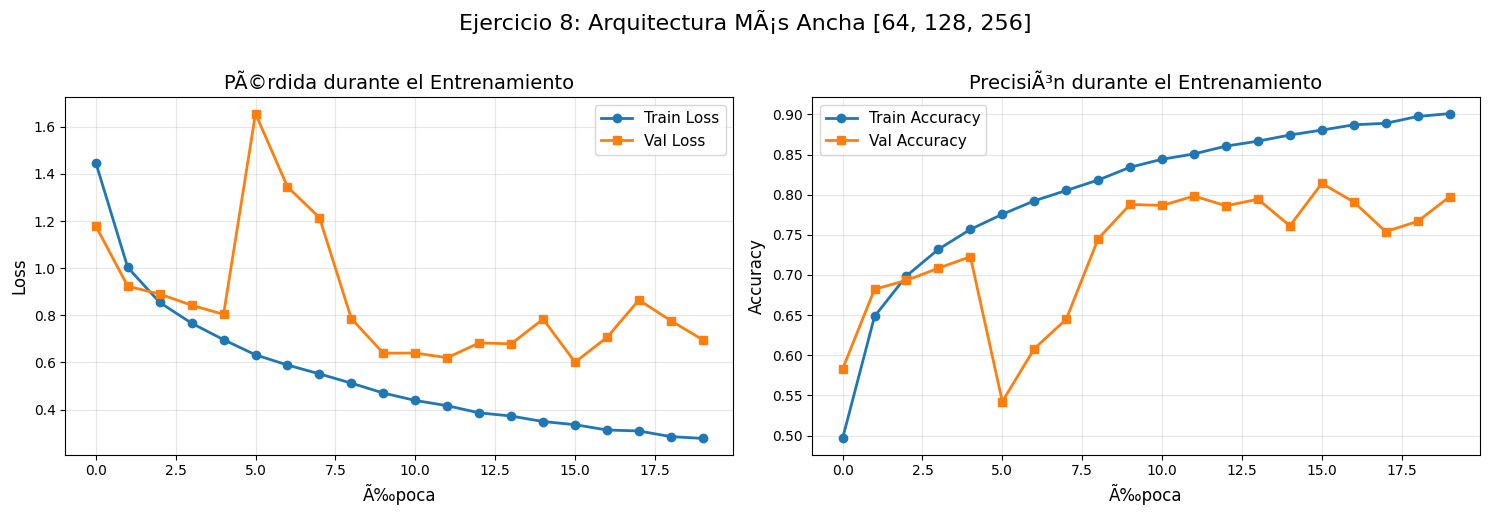

In [25]:
# Ejercicio 8: Arquitectura MÃ¡s Ancha

# TODO: Modifica los nÃºmeros de filtros a 64, 128, 256
conv_config = [
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},  # CAMBIA 32 a 64
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2},  # CAMBIA 64 a 128
    {'filters': 256, 'kernel_size': 3, 'pool_size': 2}  # CAMBIA 128 a 256
]

model_ex8 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[256],  # TambiÃ©n hacemos mÃ¡s ancha la capa densa
    dropout_rate=0.3,
    use_batch_norm=True
)

results_ex8 = train_and_evaluate(
    model_ex8,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=64,
    learning_rate=0.001,
    experiment_name="Ejercicio 8: Arquitectura MÃ¡s Ancha [64, 128, 256]"
)

### Respuestas Ejercicio 8

**8.1** Â¿MejorÃ³ la exactitud con una red mÃ¡s ancha?

Tuvo una leve mejora, pero realmente nada tan considerable.

**8.2** Â¿CuÃ¡nto aumentÃ³ el tiempo de entrenamiento?

Al final del entrenamiento no pude ver el resultado del mismo, pero si fue bastante mayor compardo con los ejercicios pasados.

**8.3** Â¿Vale la pena el costo computacional adicional?

No

---
## Ejercicio 9: Reducir Batch Size

**Objetivo**: Explorar el efecto de un batch size pequeÃ±o.

**ConfiguraciÃ³n**: Usa batch_size=16 en lugar de 64

**Pregunta**: Â¿CÃ³mo afecta el batch size al gradiente y a la convergencia?


Ejercicio 9: Batch Size PequeÃ±o (16)

Arquitectura del modelo:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,218 (1.37 MB)

 Trainable params: 357,514 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Iniciando entrenamiento...

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.4598 - loss: 1.5334 - val_accuracy: 0.6026 - val_loss: 1.1156
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.5839 - loss: 1.1814 - val_accuracy: 0.6521 - val_loss: 1.0068
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6260 - loss: 1.0682 - val_accuracy: 0.6451 - val_loss: 1.0403
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6542 - loss: 0.9878 - val_accuracy: 0.6351 - val_loss: 1.0799
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6748 - loss: 0.9359 - val_accuracy: 0.6719 - val_loss: 0.9669
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.6921 - loss: 0.8909 - val_accuracy: 0.6901 - val_loss: 0.9187
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.7061 - loss: 0.8470 - val_accuracy: 0.6844 - val_loss: 0.9432
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/st

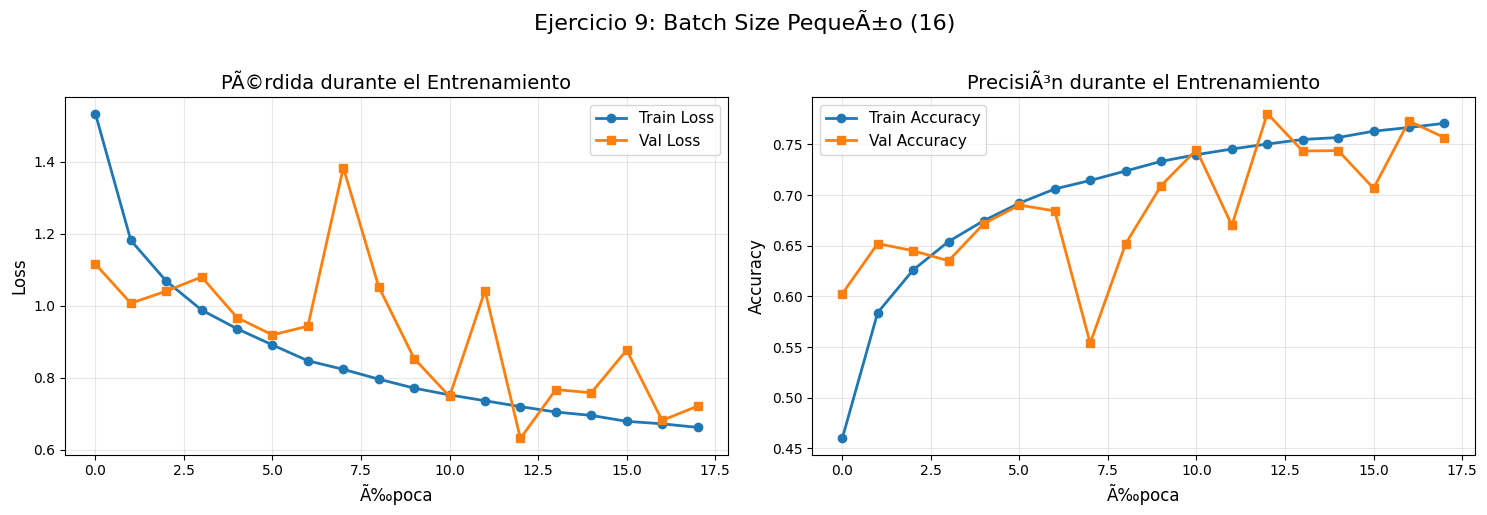

In [26]:
# Ejercicio 9: Batch Size PequeÃ±o
conv_config = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
]

model_ex9 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],
    dropout_rate=0.3,
    use_batch_norm=True
)

results_ex9 = train_and_evaluate(
    model_ex9,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=20,
    batch_size=16,  # Batch size pequeÃ±o
    learning_rate=0.001,
    experiment_name="Ejercicio 9: Batch Size PequeÃ±o (16)"
)

### Respuestas Ejercicio 9

**9.1** Â¿Las curvas de entrenamiento son mÃ¡s ruidosas?

Si

**9.2** Â¿El tiempo de entrenamiento por Ã©poca aumentÃ³?

No, pero no con respecto al ejercicio 8.

**9.3** Â¿CuÃ¡l es el trade-off entre batch size pequeÃ±o y grande?

Con el batch sizing mayor tiende a tener mejores resultados.

---
## Ejercicio 10: Modelo Ã“ptimo Combinado

**Objetivo**: DiseÃ±ar tu mejor modelo combinando las tÃ©cnicas mÃ¡s efectivas.

**TAREA**: DiseÃ±a la configuraciÃ³n Ã³ptima basÃ¡ndote en tus experimentos anteriores. Combina:
- Arquitectura apropiada (nÃºmero de capas y filtros)
- TÃ©cnicas de regularizaciÃ³n que funcionaron mejor
- HiperparÃ¡metros Ã³ptimos
- Data augmentation si es necesario

**Pregunta**: Â¿Puedes superar el 75% de accuracy en test?


Ejercicio 10: Modelo Ã“ptimo

Arquitectura del modelo:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


[INFO] Usando Data Augmentation

Iniciando entrenamiento...

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.4281 - loss: 1.5635 - val_accuracy: 0.5668 - val_loss: 1.2245
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5754 - loss: 1.1961 - val_accuracy: 0.6455 - val_loss: 0.9989
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6289 - loss: 1.0503 - val_accuracy: 0.6519 - val_loss: 1.0072
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6601 - loss: 0.9664 - val_accuracy: 0.6889 - val_loss: 0.9115
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.6832 - loss: 0.9038 - val_accuracy: 0.7056 - val_loss: 0.8459
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.6996 - loss: 0.8589 - val_accuracy: 0.7150 - val_loss: 0.8311
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.7136 - loss: 0.8162 - val_accuracy: 0.7271 - val_loss: 0.8173
Epoch 8/30
782/782 ━━━━━━━━━

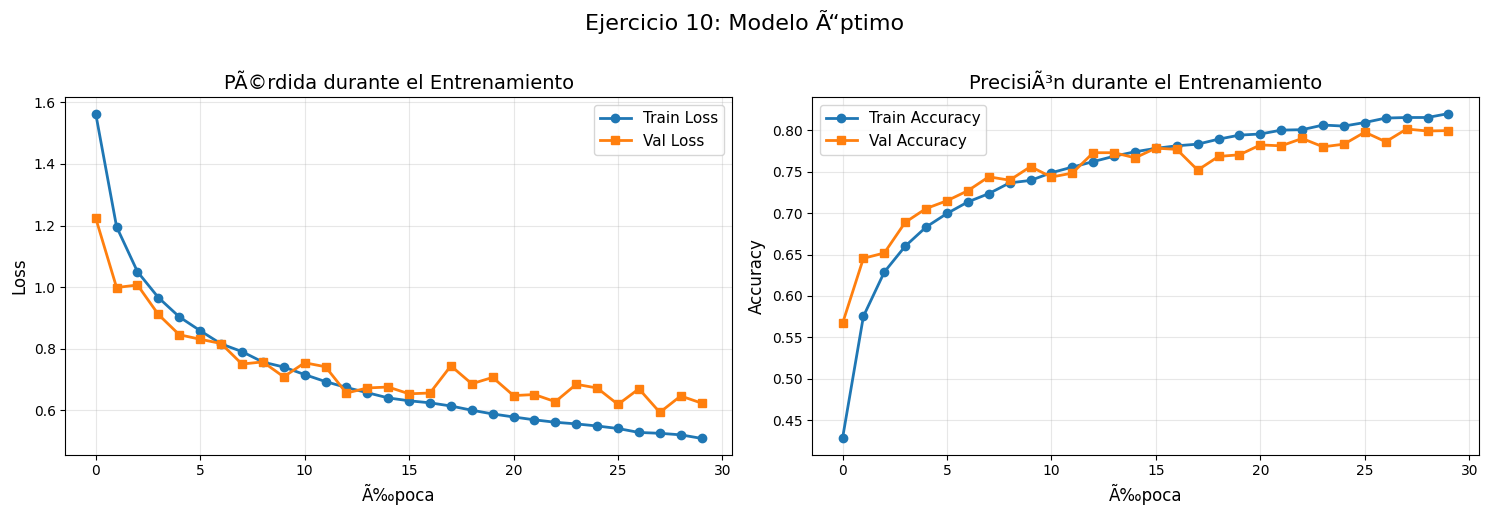

In [28]:
# Ejercicio 10: Modelo Ã“ptimo
# TODO: DiseÃ±a tu mejor configuraciÃ³n

conv_config = [
    # Define tu arquitectura Ã³ptima aquÃ­
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2},
    # Agrega mÃ¡s capas si lo consideras necesario
]

model_ex10 = build_cnn(
    conv_layers=conv_config,
    dense_layers=[128],  # Modifica segÃºn tus observaciones
    dropout_rate=0.0,  # Ajusta este valor
    use_batch_norm=False,  # Decide si usarlo
    l2_reg=0.0  # Decide si usar regularizaciÃ³n L2
)

results_ex10 = train_and_evaluate(
    model_ex10,
    X_train_processed, y_train_processed,
    X_test_processed, y_test_processed,
    epochs=30,  # Puedes aumentar las Ã©pocas
    batch_size=64,  # Ajusta segÃºn tus conclusiones
    learning_rate=0.001,  # Ajusta segÃºn tus conclusiones
    experiment_name="Ejercicio 10: Modelo Ã“ptimo",
    use_data_augmentation=True  # Decide si usarlo
)

### Respuestas Ejercicio 10

**10.1** Describe detalladamente tu configuraciÃ³n Ã³ptima y justifica cada decisiÃ³n:

- **Arquitectura (capas y filtros)**: 32, 64, 128
- **Dropout rate**: 0
- **Batch Normalization**: False
- **L2 Regularization**: 0
- **Learning rate**: 0.001
- **Batch size**: 64
- **Data Augmentation**: True

**10.2** Â¿CuÃ¡l fue tu mejor exactitud en test?

80.16%

**10.3** Â¿QuÃ© lecciones clave aprendiste sobre el diseÃ±o de CNNs?



---
## ComparaciÃ³n Final de Todos los Experimentos


COMPARACIÃ“N FINAL DE TODOS LOS EXPERIMENTOS
               Experimento Test Accuracy (%) Test Loss  Epochs Tiempo (s)
     Ejercicio 1: Baseline             68.64    0.9169       9      68.04
Ejercicio 2: 3 Conv Layers             71.96    0.8318       9      97.55
      Ejercicio 3: Dropout             70.68    0.8487      20     243.02
   Ejercicio 4: Batch Norm             70.61    0.9001       8     146.75
      Ejercicio 5: High LR             55.27    1.3869       8     148.15
     Ejercicio 6: Data Aug             80.63    0.5925      28     560.82
       Ejercicio 7: L2 Reg             71.50    1.0915      13     162.68
        Ejercicio 8: Wider             81.42    0.6013      20    1229.31
  Ejercicio 9: Small Batch             78.05    0.6314      18     514.22
     Ejercicio 10: Optimal             80.16    0.5938      30     548.95


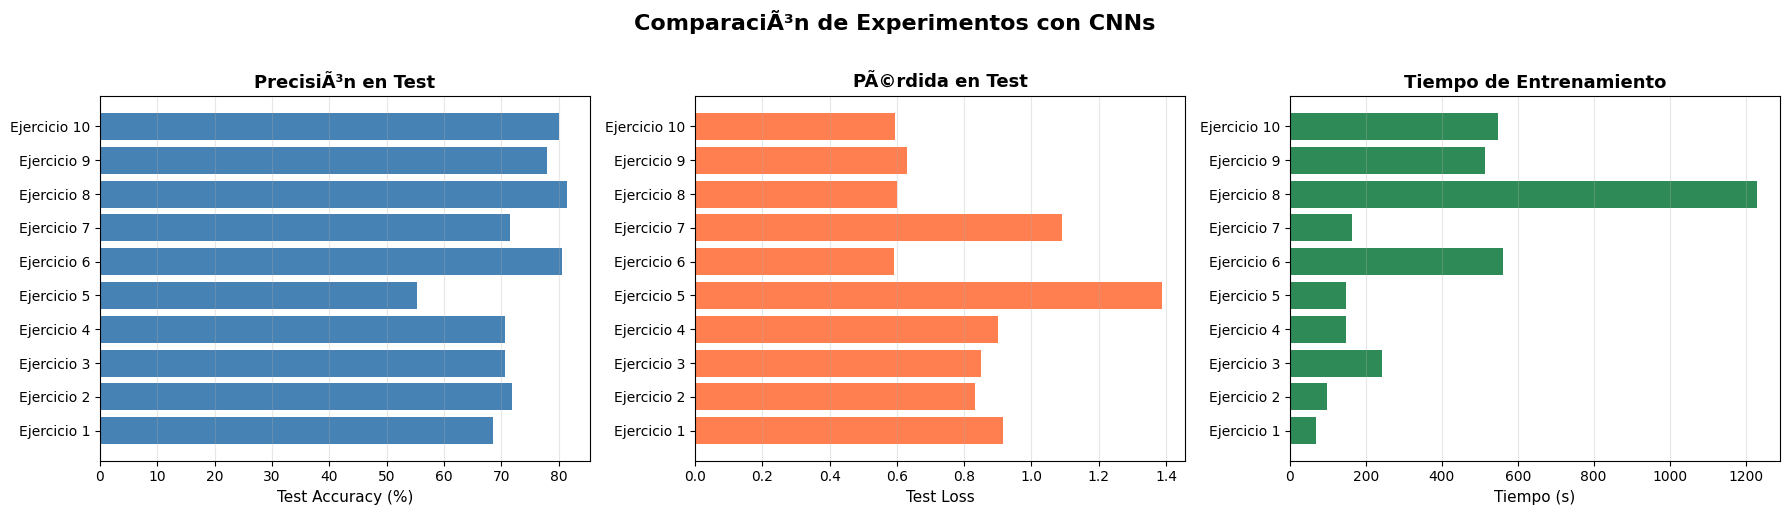


ðŸ† MEJOR MODELO: Ejercicio 8
   Accuracy: 81.42%
   Loss: 0.6013
   Tiempo: 1229.31s


In [29]:
# ComparaciÃ³n de resultados
import pandas as pd

experiments = {
    'Ejercicio 1: Baseline': results_ex1,
    'Ejercicio 2: 3 Conv Layers': results_ex2,
    'Ejercicio 3: Dropout': results_ex3,
    'Ejercicio 4: Batch Norm': results_ex4,
    'Ejercicio 5: High LR': results_ex5,
    'Ejercicio 6: Data Aug': results_ex6,
    'Ejercicio 7: L2 Reg': results_ex7,
    'Ejercicio 8: Wider': results_ex8,
    'Ejercicio 9: Small Batch': results_ex9,
    'Ejercicio 10: Optimal': results_ex10,
}

# Crear tabla comparativa
comparison_data = []
for name, result in experiments.items():
    comparison_data.append({
        'Experimento': name,
        'Test Accuracy (%)': f"{result['test_acc']*100:.2f}",
        'Test Loss': f"{result['test_loss']:.4f}",
        'Epochs': result['epochs_trained'],
        'Tiempo (s)': f"{result['training_time']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACIÃ“N FINAL DE TODOS LOS EXPERIMENTOS")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# VisualizaciÃ³n comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

experiment_names = [name.split(':')[0] for name in experiments.keys()]
accuracies = [result['test_acc']*100 for result in experiments.values()]
times = [result['training_time'] for result in experiments.values()]
losses = [result['test_loss'] for result in experiments.values()]

# Accuracy
axes[0].barh(experiment_names, accuracies, color='steelblue')
axes[0].set_xlabel('Test Accuracy (%)', fontsize=11)
axes[0].set_title('PrecisiÃ³n en Test', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Loss
axes[1].barh(experiment_names, losses, color='coral')
axes[1].set_xlabel('Test Loss', fontsize=11)
axes[1].set_title('PÃ©rdida en Test', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Time
axes[2].barh(experiment_names, times, color='seagreen')
axes[2].set_xlabel('Tiempo (s)', fontsize=11)
axes[2].set_title('Tiempo de Entrenamiento', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.suptitle('ComparaciÃ³n de Experimentos con CNNs', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Encontrar el mejor modelo
best_idx = np.argmax(accuracies)
print(f"\nðŸ† MEJOR MODELO: {experiment_names[best_idx]}")
print(f"   Accuracy: {accuracies[best_idx]:.2f}%")
print(f"   Loss: {losses[best_idx]:.4f}")
print(f"   Tiempo: {times[best_idx]:.2f}s")

---
## Conclusiones Generales

**ReflexiÃ³n Final**: Escribe un anÃ¡lisis de al menos 200 palabras resumiendo:

1. Las tÃ©cnicas que mÃ¡s impactaron el desempeÃ±o de tu CNN
2. Los trade-offs entre complejidad del modelo y desempeÃ±o
3. CÃ³mo diferentes tÃ©cnicas de regularizaciÃ³n afectan el overfitting
4. Lecciones sobre el diseÃ±o de arquitecturas de CNNs para computer vision
5. Recomendaciones para futuros proyectos de clasificaciÃ³n de imÃ¡genes

*Tu reflexiÃ³n aquÃ­ (mÃ­nimo 200 palabras)*

---
---
# APÃ‰NDICE: Cargar ImÃ¡genes desde el Disco con TensorFlow

## âš ï¸ NO EJECUTAR - SOLO COMO REFERENCIA

Esta secciÃ³n muestra cÃ³mo usar `tf.keras.preprocessing.image_dataset_from_directory` para cargar imÃ¡genes organizadas en carpetas por clase.

### Estructura de Carpetas Requerida

```
dataset/
â”œâ”€â”€ train/
â”‚   â”œâ”€â”€ clase_1/
â”‚   â”‚   â”œâ”€â”€ imagen_001.jpg
â”‚   â”‚   â”œâ”€â”€ imagen_002.jpg
â”‚   â”‚   â””â”€â”€ ...
â”‚   â”œâ”€â”€ clase_2/
â”‚   â”‚   â”œâ”€â”€ imagen_001.jpg
â”‚   â”‚   â””â”€â”€ ...
â”‚   â””â”€â”€ clase_3/
â”‚       â””â”€â”€ ...
â””â”€â”€ test/
    â”œâ”€â”€ clase_1/
    â”œâ”€â”€ clase_2/
    â””â”€â”€ clase_3/
```

**Importante**: El nombre de cada subcarpeta serÃ¡ usado automÃ¡ticamente como el nombre de la clase.

### Ejemplo 1: Cargar Dataset BÃ¡sico

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar dataset de entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',  # Ruta a la carpeta de entrenamiento
    image_size=(224, 224),  # Redimensionar todas las imÃ¡genes a 224x224
    batch_size=32,  # TamaÃ±o del batch
    label_mode='categorical',  # Para clasificaciÃ³n multiclase
    seed=42  # Para reproducibilidad
)

# Cargar dataset de validaciÃ³n
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    seed=42
)

# Ver nombres de las clases
class_names = train_ds.class_names
print(f'Clases encontradas: {class_names}')
print(f'NÃºmero de clases: {len(class_names)}')

### Ejemplo 2: Con Split AutomÃ¡tico Train/Validation

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar todo el dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/all_images',  # Carpeta con todas las imÃ¡genes
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,  # 20% para validaciÃ³n
    subset='training',  # Especificar que esto es el conjunto de entrenamiento
    seed=42
)

# Cargar el conjunto de validaciÃ³n
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/all_images',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',  # Especificar que esto es el conjunto de validaciÃ³n
    seed=42
)

### Ejemplo 3: Con Preprocesamiento y Data Augmentation

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# NormalizaciÃ³n de pÃ­xeles [0, 255] -> [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Aplicar preprocesamiento
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# OptimizaciÃ³n del pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Ejemplo 4: Visualizar ImÃ¡genes Cargadas

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Visualizar un batch de imÃ¡genes
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Convertir one-hot a Ã­ndice de clase
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[class_idx])
        plt.axis("off")
plt.tight_layout()
plt.show()

### Ejemplo 5: Usar con un Modelo

In [ ]:
# NO EJECUTAR - EJEMPLO DE REFERENCIA

# Cargar datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Normalizar
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Optimizar pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Construir modelo
num_classes = len(train_ds.class_names)
model = build_cnn(
    input_shape=(224, 224, 3),
    num_classes=num_classes,
    conv_layers=[
        {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
        {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
        {'filters': 128, 'kernel_size': 3, 'pool_size': 2}
    ],
    dense_layers=[256],
    dropout_rate=0.5,
    use_batch_norm=True
)

# Compilar
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar directamente con los datasets
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

### ParÃ¡metros Importantes de `image_dataset_from_directory`

- **`directory`**: Ruta a la carpeta que contiene las subcarpetas de clases
- **`image_size`**: Tupla (height, width) para redimensionar las imÃ¡genes
- **`batch_size`**: NÃºmero de imÃ¡genes por batch (default: 32)
- **`label_mode`**: 
  - `'int'`: Etiquetas como enteros
  - `'categorical'`: One-hot encoding (para clasificaciÃ³n multiclase)
  - `'binary'`: Para clasificaciÃ³n binaria
- **`color_mode`**: 
  - `'rgb'`: ImÃ¡genes a color (default)
  - `'grayscale'`: ImÃ¡genes en escala de grises
- **`validation_split`**: FracciÃ³n de datos para validaciÃ³n (e.g., 0.2 para 20%)
- **`subset`**: `'training'` o `'validation'` (requerido si se usa validation_split)
- **`seed`**: Semilla para reproducibilidad
- **`shuffle`**: Si mezclar los datos (default: True)

### Notas Importantes

1. Las imÃ¡genes se cargan de forma lazy (on-demand), ahorrando memoria
2. Usa `.cache()` y `.prefetch()` para optimizar el pipeline de datos
3. Las imÃ¡genes se cargan con valores en [0, 255], recuerda normalizarlas
4. Soporta formatos: PNG, JPG, BMP, GIF
5. Los nombres de las carpetas se convierten automÃ¡ticamente en etiquetas